Using device: cuda
Classes: ['NORMAL', 'PNEUMONIA']


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\Stavya/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:08<00:00, 5.58MB/s]



Epoch 1/10
train Loss: 0.3149 Acc: 0.8622
val Loss: 0.2632 Acc: 0.8750

Epoch 2/10
train Loss: 0.1840 Acc: 0.9245
val Loss: 0.3462 Acc: 0.8125

Epoch 3/10
train Loss: 0.1631 Acc: 0.9373
val Loss: 0.2800 Acc: 0.8125

Epoch 4/10
train Loss: 0.1426 Acc: 0.9454
val Loss: 0.3426 Acc: 0.8125

Epoch 5/10
train Loss: 0.1459 Acc: 0.9425
val Loss: 0.5096 Acc: 0.6875

Epoch 6/10
train Loss: 0.1461 Acc: 0.9377
val Loss: 0.2940 Acc: 0.8125

Epoch 7/10
train Loss: 0.1407 Acc: 0.9450
val Loss: 0.2178 Acc: 0.9375

Epoch 8/10
train Loss: 0.1309 Acc: 0.9500
val Loss: 0.4775 Acc: 0.6875

Epoch 9/10
train Loss: 0.1342 Acc: 0.9500
val Loss: 0.3365 Acc: 0.8125

Epoch 10/10
train Loss: 0.1285 Acc: 0.9488
val Loss: 0.4092 Acc: 0.8125

✅ Training complete. Best val acc: 0.9375

📊 Evaluating on Test Set...


C:\Users\Stavya\AppData\Local\Temp\ipykernel_12152\2548341780.py:129: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pth"))



Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.92      0.77      0.84       234
   PNEUMONIA       0.88      0.96      0.92       390

    accuracy                           0.89       624
   macro avg       0.90      0.87      0.88       624
weighted avg       0.89      0.89      0.89       624



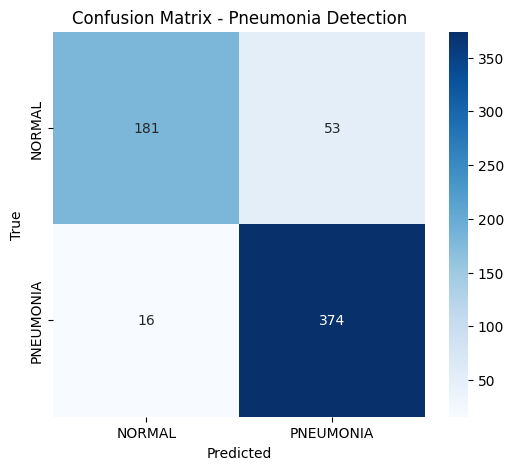

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import time

data_dir = r"D:/code/Pneumonia Detection/chest_xray"  # 🔹 change this path
batch_size = 32
num_classes = 2   # NORMAL vs PNEUMONIA
num_epochs = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

data_transforms = {
    "train": transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    "val": transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    "test": transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
}

# LOAD DATA
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val', 'test']}
dataloaders = {x: DataLoader(image_datasets[x], batch_size=batch_size,
                             shuffle=True, num_workers=2)
               for x in ['train', 'val', 'test']}

class_names = image_datasets['train'].classes
print("Classes:", class_names)


# MODEL: RESNET18 TRANSFER LEARNING
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

# Freeze backbone
for param in model.parameters():
    param.requires_grad = False

# Replace final layer
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)


# LOSS + OPTIMIZER
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)


# TRAINING LOOP
best_acc = 0.0
for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")

    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()
        else:
            model.eval()

        running_loss, running_corrects = 0.0, 0

        for inputs, labels in dataloaders[phase]:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                preds = torch.argmax(outputs, 1)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(image_datasets[phase])
        epoch_acc = running_corrects.double() / len(image_datasets[phase])

        print(f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

        # save best model
        if phase == 'val' and epoch_acc > best_acc:
            best_acc = epoch_acc
            torch.save(model.state_dict(), "best_model.pth")

print("\n✅ Training complete. Best val acc: {:.4f}".format(best_acc))


# TEST EVALUATION
print("\n📊 Evaluating on Test Set...")
model.load_state_dict(torch.load("best_model.pth"))
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in dataloaders['test']:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        preds = torch.argmax(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Classification report
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Pneumonia Detection")
plt.show()


In [29]:
torch.save(model.state_dict(), "pneu.pth")
